In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


import os
import cv2

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split


from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import plot_roc_curve, auc,roc_curve,roc_auc_score


(190, 200, 3)


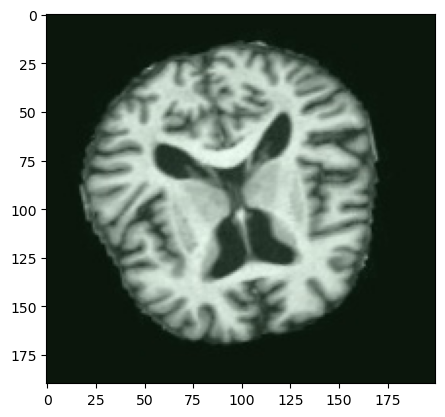

In [22]:
# loading and testing out data 
img = cv2.imread(os.path.join('Data','VeryMildDemented','2b70a7c4-b97a-4887-8e5f-85c079e7b275.jpg'))
print(img.shape)
plt.imshow(img);
# plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB));
# if you have color problem use this 

# Load Data

In [23]:
data_dir = 'Data'
class_labels = ['VeryMildDemented', 'ModerateDemented', 'MildDemented', 'NonDemented']
image_size = (50, 50) # Desired image size

In [24]:
# Load the images and labels:
img = []
lbl = []

for label_idx, label in enumerate(class_labels):
    folder_path = os.path.join(data_dir, label)
    for image_file in os.listdir(folder_path):
        image_path = os.path.join(folder_path, image_file) # get the image
        image = cv2.imread(image_path) # read the image
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
        image = cv2.resize(image, image_size)  # Resize the image
        img.append(image)
        lbl.append(label_idx)

In [25]:
# Convert the images and labels to numpy arrays:
images = np.array(img)
labels = np.array(lbl)

# Train, Test, Split

In [26]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

In [27]:
x_train = X_train/255 # normalization
x_test = X_test/255

In [28]:
# Keras requires multi-class labels to be one-hot encoded
y_tr_one_hot = to_categorical(y_train)
y_tt_one_hot = to_categorical(y_test)
y_tt_one_hot

array([[0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       ...,
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.]], dtype=float32)

In [29]:
x_train.shape

(27187, 50, 50, 3)

# Build Model

In [31]:
# model = Sequential()
# model.add(Conv2D(16, (3,3), 1, activation = 'relu', input_shape =(50,50,3))) # 16 filter with (3,3) pixel in size, 
# #model looks at 1 pixel at a time
# model.add(MaxPooling2D()) # max pool take the max value of the region it looks at and return that max value, 
# #default (2,2)


# model.add(Conv2D(32, (3,3), 1, activation = 'relu')) # 32 filter
# model.add(MaxPooling2D())


# model.add(Conv2D(16, (3,3), 1, activation = 'relu')) # 16 filter
# model.add(MaxPooling2D())


# model.add(Flatten())

# model.add(Dense(256, activation='relu'))
# model.add(Dense(4, activation='softmax'))



# Trying a similar architecture as VG16
model = Sequential()
model.add(Conv2D(64, (3,3), 1, activation = 'relu', input_shape =(50,50,3)))
model.add(Conv2D(64, (3,3), 1, activation = 'relu'))
model.add(MaxPooling2D())

model.add(Conv2D(128, (3,3), 1, activation = 'relu'))
model.add(Conv2D(128, (3,3), 1, activation = 'relu'))
model.add(MaxPooling2D())

model.add(Conv2D(256, (3,3), 1, activation = 'relu'))
model.add(Conv2D(256, (3,3), 1, activation = 'relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(4, activation='softmax'))

In [32]:
opt = Adam(learning_rate = 1e-5, beta_1 = 0.9, beta_2 = 0.999 ) # typical parameters

In [33]:
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy','AUC'] )

In [34]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 48, 48, 64)        1792      
                                                                 
 conv2d_17 (Conv2D)          (None, 46, 46, 64)        36928     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 23, 23, 64)       0         
 2D)                                                             
                                                                 
 conv2d_18 (Conv2D)          (None, 21, 21, 128)       73856     
                                                                 
 conv2d_19 (Conv2D)          (None, 19, 19, 128)       147584    
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 9, 9, 128)        0         
 g2D)                                                 

# Visualize the Model

In [35]:
# visualizer(model, file_format='png', view=True, file_name='Conv2D_model')

# Fit Model

In [36]:
#  will use validation loss: stopping to prevent overfitting.
trainCallback = EarlyStopping(monitor='loss', min_delta = 1e-6, patience = 5)

In [37]:
history_model = model.fit(x_train, y_tr_one_hot, epochs=100, batch_size= 32, validation_split = 0.2, 
                 callbacks = [trainCallback] )

Epoch 1/100


2023-07-18 12:33:15.627110: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


680/680 [==============================] - ETA: 0s - loss: 1.3356 - accuracy: 0.3346 - auc: 0.6186

2023-07-18 12:33:32.047292: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


680/680 [==============================] - 19s 26ms/step - loss: 1.3356 - accuracy: 0.3346 - auc: 0.6186 - val_loss: 1.2456 - val_accuracy: 0.4025 - val_auc: 0.7038
Epoch 2/100
680/680 [==============================] - 17s 25ms/step - loss: 1.2255 - accuracy: 0.4197 - auc: 0.7093 - val_loss: 1.1585 - val_accuracy: 0.4974 - val_auc: 0.7588
Epoch 3/100
680/680 [==============================] - 17s 25ms/step - loss: 1.1210 - accuracy: 0.4943 - auc: 0.7694 - val_loss: 1.0709 - val_accuracy: 0.5338 - val_auc: 0.7935
Epoch 4/100
680/680 [==============================] - 17s 26ms/step - loss: 1.0127 - accuracy: 0.5403 - auc: 0.8146 - val_loss: 0.9589 - val_accuracy: 0.5715 - val_auc: 0.8380
Epoch 5/100
680/680 [==============================] - 18s 26ms/step - loss: 0.9324 - accuracy: 0.5727 - auc: 0.8425 - val_loss: 0.9155 - val_accuracy: 0.5925 - val_auc: 0.8495
Epoch 6/100
680/680 [==============================] - 17s 26ms/step - loss: 0.8734 - accuracy: 0.5988 - auc: 0.8609 - val_loss

680/680 [==============================] - 18s 26ms/step - loss: 0.2426 - accuracy: 0.9085 - auc: 0.9903 - val_loss: 0.4524 - val_accuracy: 0.8222 - val_auc: 0.9651
Epoch 48/100
680/680 [==============================] - 18s 26ms/step - loss: 0.2344 - accuracy: 0.9124 - auc: 0.9908 - val_loss: 0.4628 - val_accuracy: 0.8132 - val_auc: 0.9632
Epoch 49/100
680/680 [==============================] - 17s 25ms/step - loss: 0.2219 - accuracy: 0.9173 - auc: 0.9920 - val_loss: 0.4646 - val_accuracy: 0.8279 - val_auc: 0.9646
Epoch 50/100
680/680 [==============================] - 17s 25ms/step - loss: 0.2141 - accuracy: 0.9194 - auc: 0.9925 - val_loss: 0.4235 - val_accuracy: 0.8431 - val_auc: 0.9693
Epoch 51/100
680/680 [==============================] - 17s 26ms/step - loss: 0.2076 - accuracy: 0.9241 - auc: 0.9929 - val_loss: 0.4362 - val_accuracy: 0.8430 - val_auc: 0.9679
Epoch 52/100
680/680 [==============================] - 18s 26ms/step - loss: 0.1954 - accuracy: 0.9298 - auc: 0.9939 - val

680/680 [==============================] - 17s 25ms/step - loss: 0.0083 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 0.5360 - val_accuracy: 0.8889 - val_auc: 0.9672
Epoch 94/100
680/680 [==============================] - 17s 25ms/step - loss: 0.0081 - accuracy: 0.9995 - auc: 1.0000 - val_loss: 0.5456 - val_accuracy: 0.8838 - val_auc: 0.9675
Epoch 95/100
680/680 [==============================] - 18s 26ms/step - loss: 0.0583 - accuracy: 0.9821 - auc: 0.9983 - val_loss: 0.5157 - val_accuracy: 0.8873 - val_auc: 0.9685
Epoch 96/100
680/680 [==============================] - 18s 26ms/step - loss: 0.0074 - accuracy: 0.9999 - auc: 1.0000 - val_loss: 0.5234 - val_accuracy: 0.8867 - val_auc: 0.9694
Epoch 97/100
680/680 [==============================] - 17s 25ms/step - loss: 0.0129 - accuracy: 0.9977 - auc: 1.0000 - val_loss: 0.5309 - val_accuracy: 0.8878 - val_auc: 0.9684
Epoch 98/100
680/680 [==============================] - 17s 25ms/step - loss: 0.0052 - accuracy: 1.0000 - auc: 1.0000 - val

# Evaluate Model

In [38]:
# probability for each class
y_proba = model.predict(x_test)
y_proba

 19/213 [=>............................] - ETA: 1s

2023-07-18 13:02:56.169953: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


213/213 [==============================] - 2s 8ms/step


array([[5.4894117e-06, 2.6461937e-24, 9.9999392e-01, 5.4811960e-07],
       [9.9701905e-01, 1.5109724e-34, 1.5382578e-07, 2.9808963e-03],
       [9.9486615e-06, 2.7313736e-14, 9.9999011e-01, 4.4114940e-13],
       ...,
       [1.5130938e-03, 0.0000000e+00, 9.0641557e-13, 9.9848688e-01],
       [1.2983825e-06, 0.0000000e+00, 7.5068476e-20, 9.9999869e-01],
       [3.9824481e-06, 2.2818205e-16, 9.9999249e-01, 3.5999565e-06]],
      dtype=float32)

In [39]:
model.evaluate(x_test, y_tt_one_hot)

213/213 [==============================] - 3s 13ms/step - loss: 0.5182 - accuracy: 0.8910 - auc: 0.9707


[0.518193781375885, 0.8909813165664673, 0.9706955552101135]

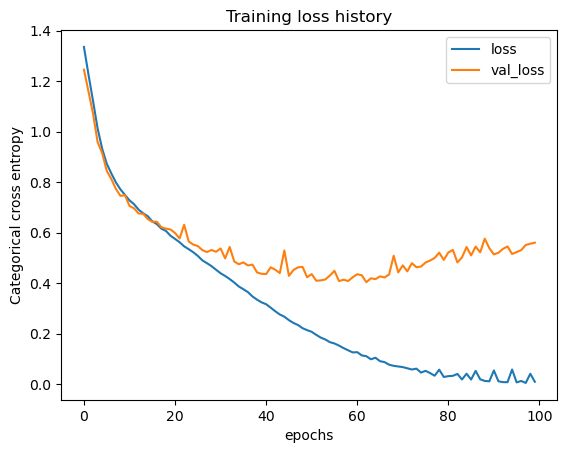

In [40]:
train_history_model = pd.DataFrame(history_model.history)
train_history_model.index.name = 'epochs'

col_list = ['loss', 'val_loss']
train_history_model[col_list].plot()
plt.ylabel('Categorical cross entropy')
plt.title('Training loss history')
plt.show()

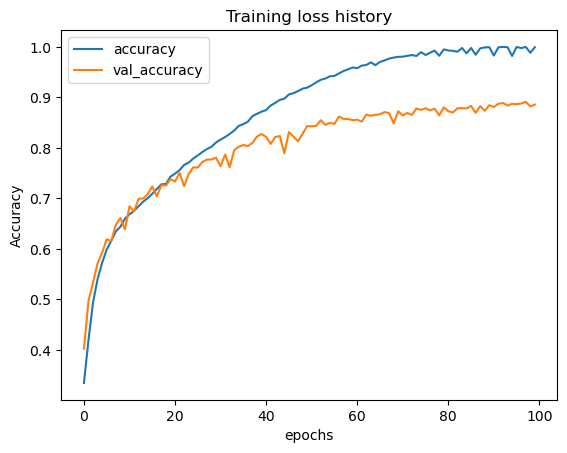

In [41]:
col_list = ['accuracy', 'val_accuracy']
train_history_model[col_list].plot()
plt.ylabel('Accuracy')
plt.title('Training loss history')
plt.show()

In [42]:
# argmax axis = -1 gets the column index of maximum probability for each row.
# column index corresponds to digit classes (numbers 0 -9)
predicted = np.argmax(y_proba, axis=-1)
predicted

array([2, 0, 2, ..., 3, 3, 2])

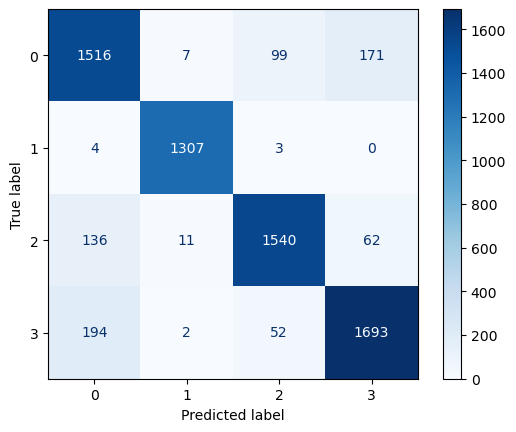

In [43]:
cm_class = confusion_matrix(y_test, predicted)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm_class)

disp.plot(cmap=plt.cm.Blues)
plt.show()